In [19]:
# Start coding here
# Use as many cells as you need


# Import required libraries
import pandas as pd
import nannyml as nml
nml.disable_usage_logging()

reference = pd.read_csv("../data/analysis.csv")
analysis = pd.read_csv("../data/reference.csv")



/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.



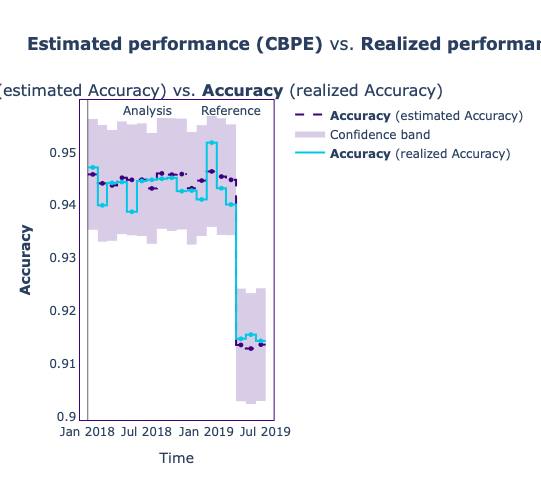

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.



['april_2019', 'may_2019', 'june_2019']


/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/drift/ranker.py:376: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



,column_name,pearsonr_correlation,pearsonr_pvalue,has_drifted,rank
0,time_since_login_min,0.588445,0.010202,False,1
1,is_first_transaction,0.231965,0.354337,True,2
2,transaction_amount,0.166387,0.509339,False,3
3,user_tenure_months,0.148045,0.557705,False,4
4,transaction_type,0.066532,0.793092,True,5


time_since_login_min


/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.

/opt/anaconda3/lib/python3.12/site-packages/nannyml/chunk.py:294: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'M' instead.



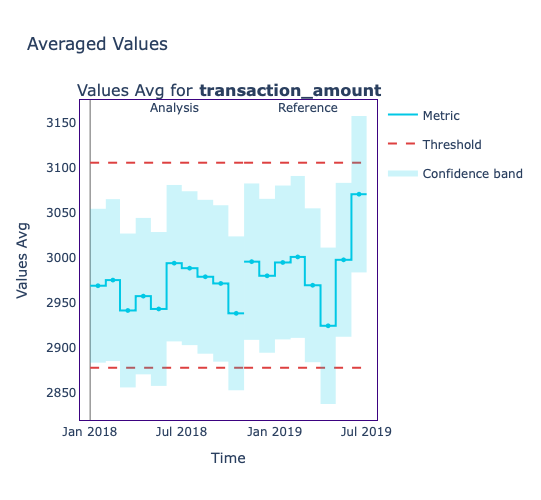

3069.8184


'\nFirst, I recommend looking at the distribution plots for all features and analyzing them using this command: \n- `univariate_data_drift.filter(column_names=features).plot(kind="distribution")`\n\nObservations:\n\n- time_since_log_min - From April to June, the transactions made within one minute after logging in completely vanished.\n- transaction_amount - In May and June, a larger number of transactions appeared. Additionally, as you discovered in the third question, the average transaction value has increased and raised an alert.\n\nPossible explanation: \n\nFraudsters may have noticed that early card transactions, when done right after logging in, often led to account blocking. As a result, they began waiting a bit longer before transferring money to their account to avoid detection. Furthermore, they tend to make a single larger transfer instead of many smaller ones, leading to an increase in the average transaction value.\n'

In [27]:
## Identifing the months when both the estimated and realized ROC AUC of the model have alerts. Store the names of these months as lowercase strings in a list named months_with_performance_alerts. 

# Get the estimated performance using CBPE algorithm
cbpe = nml.CBPE(
    timestamp_column_name="timestamp",
    y_true="is_fraud",
    y_pred="predicted_fraud",
    y_pred_proba="predicted_fraud_proba",
    problem_type="classification_binary",
    metrics=["accuracy"],
    chunk_period="m"
)

cbpe.fit(reference)
est_results = cbpe.estimate(analysis)

# Calculate the realized performance
calculator = nml.PerformanceCalculator(
    y_true="is_fraud",
    y_pred="predicted_fraud",
    y_pred_proba="predicted_fraud_proba",
    timestamp_column_name="timestamp",
    metrics=["accuracy"],
    chunk_period="m",
    problem_type="classification_binary",
)
calculator = calculator.fit(reference)
calc_results = calculator.calculate(analysis)

# Compare the results and find the months with alerts
est_results.compare(calc_results).plot().show()
months_with_performance_alerts = ["april_2019", "may_2019", "june_2019"]
print(months_with_performance_alerts)

## Determining which alerting feature has the strongest correlation with the model’s realized performance. Store the name of this feature in a variable named highest_correlation_feature. 

features = ["time_since_login_min", "transaction_amount",
            "transaction_type", "is_first_transaction", 
            "user_tenure_months"]

# Calculate the univariate drift results
udc = nml.UnivariateDriftCalculator(
    timestamp_column_name="timestamp",
    column_names=features,
    chunk_period="m",
    continuous_methods=["kolmogorov_smirnov"],
    categorical_methods=["chi2"]
)

udc.fit(reference)
udc_results = udc.calculate(analysis)

# Use the correlation ranker
ranker = nml.CorrelationRanker()
ranker.fit(
    calc_results.filter(period="reference"))

correlation_ranked_features = ranker.rank(udc_results, calc_results)

# Find the highest correlating feature
display(correlation_ranked_features)
highest_correlation_feature = "time_since_login_min"
print(highest_correlation_feature)

## Use the summary average statistics calculator to find out what were the monthly average transactions amounts, and if there's any alert. Record this value in a variable called alert_avg_transaction_amount.

# Calculate average monthly transactions
calc = nml.SummaryStatsAvgCalculator(
    column_names=["transaction_amount"],
    chunk_period="m",
    timestamp_column_name="timestamp",
)

calc.fit(reference)
stats_avg_results = calc.calculate(analysis)

# Find the month
stats_avg_results.plot().show()
alert_avg_transaction_amount = 3069.8184
print(alert_avg_transaction_amount)

## Answer to the bonus question
"""
First, I recommend looking at the distribution plots for all features and analyzing them using this command: 
- `univariate_data_drift.filter(column_names=features).plot(kind="distribution")`

Observations:

- time_since_log_min - From April to June, the transactions made within one minute after logging in completely vanished.
- transaction_amount - In May and June, a larger number of transactions appeared. Additionally, as you discovered in the third question, the average transaction value has increased and raised an alert.

Possible explanation: 

Fraudsters may have noticed that early card transactions, when done right after logging in, often led to account blocking. As a result, they began waiting a bit longer before transferring money to their account to avoid detection. Furthermore, they tend to make a single larger transfer instead of many smaller ones, leading to an increase in the average transaction value.
"""